# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 32
element_types = [1, 2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

In [8]:
element_gameweek_df['clean_sheets_no_time'] =\
element_gameweek_df['goals_conceded'].apply(lambda x: 1 if x == 0 else 0)

In [9]:
element_gameweek_df['row_id'] = element_gameweek_df['row_id'].rank()

In [10]:
element_gameweek_df['element_fixture_rank'] = element_gameweek_df.groupby('element')['row_id'].rank()

In [11]:
rolling_df = \
element_gameweek_df.copy().groupby('element', as_index=True)[['minutes', 'goals_conceded']]\
.rolling(38, min_periods=1).sum().reset_index()[['element', 'minutes', 'goals_conceded']]

In [12]:
rolling_df['element_fixture_rank'] = rolling_df.groupby('element')['minutes'].rank()

In [13]:
rolling_df['element_fixture_rank'] = rolling_df['element_fixture_rank'] + 1

In [14]:
element_gameweek_df =\
element_gameweek_df.join(
    rolling_df.set_index(['element', 'element_fixture_rank']),
    on=['element', 'element_fixture_rank'],
    rsuffix='_rolling')

In [15]:
element_gameweek_df['goals_conceded_per_minute_rolling'] = \
element_gameweek_df['goals_conceded_rolling'] / element_gameweek_df['minutes_rolling']

In [16]:
element_gameweek_df.head()

,row_id,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,team,web_name,safe_web_name,own_team,opposition_team,clean_sheets_no_time,element_fixture_rank,minutes_rolling,goals_conceded_rolling,goals_conceded_per_minute_rolling
0,1.0,0,42,0,0,0,24,0,2,31,...,1,Cech,cech,1,13,0,1.0,NaN,NaN,NaN
1,2.0,0,35,0,0,0,26,0,1,25,...,1,Cech,cech,1,6,0,2.0,90.0,2.0,0.022222
2,3.0,0,24,0,0,0,17,0,0,20,...,1,Cech,cech,1,19,0,3.0,180.0,5.0,0.027778
3,4.0,0,38,0,0,0,8,0,0,24,...,1,Cech,cech,1,5,0,4.0,270.0,6.0,0.022222
4,5.0,0,33,0,0,0,13,0,2,23,...,1,Cech,cech,1,15,0,5.0,360.0,8.0,0.022222


In [17]:
element_gameweek_df.columns

Index(['row_id', 'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards', 'event', 'team_a',
       'team_a_difficulty', 'team_h', 'team

# Models

## Simple Binomial model

### Preparing data

In [18]:
spm_df = element_gameweek_df.copy()

In [19]:
spm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling', 'goals_conceded_per_minute_rolling'
]

In [20]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [21]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'clean_sheets_no_time')

In [22]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [23]:
spm_response_df.head()

0    0
1    0
2    0
3    0
4    0
Name: clean_sheets_no_time, dtype: int64

### Fitting model

In [24]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [25]:
print(spm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8802
Model:                              GLM   Df Residuals:                     8801
Model Family:                  Binomial   Df Model:                            0
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -5817.0
Date:                  Tue, 09 Apr 2019   Deviance:                       11634.
Time:                          15:27:46   Pearson chi2:                 8.80e+03
No. Iterations:                       4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5165      0.022    -23.444      0.000      -0.560      -0.473


### Model fit

In [26]:
spm_results.aic

11636.08788631826

In [27]:
spm_results.bic

-68303.05622479423

In [28]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(False, 0.49498863746464794)

In [29]:
spm_results.resid_deviance.describe()

count    8802.000000
mean       -0.081574
std         1.146844
min        -0.967337
25%        -0.967337
50%        -0.967337
75%         1.403136
max         1.403136
dtype: float64

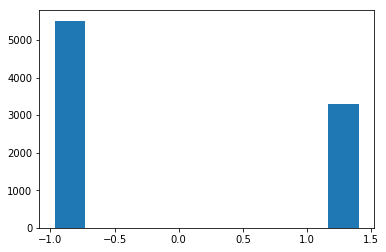

In [30]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Binomial minutes model

### Preparing data

In [31]:
spmm_df = element_gameweek_df.copy()

In [32]:
spmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling', 'goals_conceded_per_minute_rolling'
]

In [33]:
spmm_df['log_minutes'] = np.log(spmm_df['minutes'])

In [34]:
spmm_df = player.remove_redundant_columns(spmm_df, spmm_redundant_columns)

In [35]:
spmm_response_df, spmm_explanatory_df = player.get_response_explanatory_dfs(spmm_df, 'clean_sheets_no_time')

In [36]:
spmm_explanatory_df.columns

Index(['const', 'log_minutes'], dtype='object')

### Fitting model

In [37]:
spmm_results = sm.GLM(
    spmm_response_df,
    spmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [38]:
print(spmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8802
Model:                              GLM   Df Residuals:                     8800
Model Family:                  Binomial   Df Model:                            1
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -5253.5
Date:                  Tue, 09 Apr 2019   Deviance:                       10507.
Time:                          15:27:47   Pearson chi2:                 9.00e+03
No. Iterations:                       5                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.3506      0.142     23.627      0.000       3.073       3.629
log_minutes    -0.9526      0.0

### Model fit

In [39]:
spmm_results.aic

10510.915651966397

In [40]:
spmm_results.bic

-69421.14572489871

In [41]:
spmm_pearson_results = goodness_fit.pearson_chi_squared_test(spmm_results)
spmm_pearson_results

(False, 0.06529483547864734)

In [42]:
spmm_results.resid_deviance.describe()

count    8802.000000
mean       -0.082833
std         1.089481
min        -2.601930
25%        -0.813505
50%        -0.813505
75%         1.117368
max         1.591756
dtype: float64

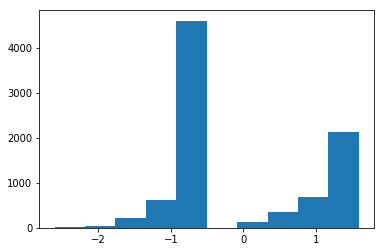

In [43]:
plt.figure()
plt.hist(spmm_results.resid_deviance)
plt.show()

## Simple Binomial teams model

### Preparing data

In [44]:
sptm_df = element_gameweek_df.copy()

In [45]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [46]:
sptm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling', 'goals_conceded_per_minute_rolling'
]

In [47]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [48]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'clean_sheets_no_time')

In [49]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_2', 'element_type_3',
       'element_type_4', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       'opposition_team_10', 'opposition_team_11', 'opposition_team_12',
       'opposition_team_13', 'opposition_team_14', 'opposition_team_15',
       'opposition_team_16', 'opposition_team_17', 'opposition_team_18',
       'opposition_team_19', 'opposition_team_20', 'own_team_2', 'own_team_3',
       'own_team_4', 'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8',
       'own_team_9', 'own_team_10', 'own_team_11', 'own_team_12',
       'own_team_13', 'own_team_14', 'own_team_15', 'own_team_16',
       'own_team_17', 'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [50]:
sptm_response_df.head()

0    0
1    0
2    0
3    0
4    0
Name: clean_sheets_no_time, dtype: int64

### Fitting model

In [51]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [52]:
print(sptm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8802
Model:                              GLM   Df Residuals:                     8759
Model Family:                  Binomial   Df Model:                           42
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -5227.3
Date:                  Tue, 09 Apr 2019   Deviance:                       10455.
Time:                          15:27:48   Pearson chi2:                 8.74e+03
No. Iterations:                       4                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3674      0.192    -12.336      0.000      -2.744      -1.991
was_home  

### Model fit

In [53]:
sptm_results.aic

10540.643954975792

In [54]:
sptm_results.bic

-69101.02531774712

In [55]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(False, 0.5420842163157938)

In [56]:
sptm_results.resid_deviance.describe()

count    8802.000000
mean       -0.073518
std         1.087422
min        -2.103928
25%        -0.935487
50%        -0.634923
75%         1.120921
max         2.367661
dtype: float64

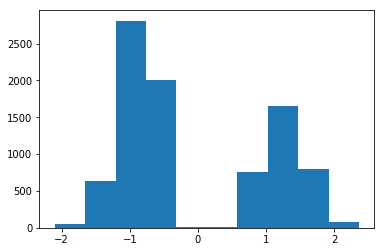

In [57]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Binomial teams minutes model

### Preparing data

In [58]:
sptmm_df = element_gameweek_df.copy()

In [59]:
sptmm_df = player.add_categorical_variables(sptmm_df, 'element_type')
sptmm_df = player.add_categorical_variables(sptmm_df, 'opposition_team')
sptmm_df = player.add_categorical_variables(sptmm_df, 'own_team')

In [60]:
sptmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling', 'goals_conceded_per_minute_rolling'
]

In [61]:
sptmm_df['log_minutes'] = np.log(sptmm_df['minutes'])

In [62]:
sptmm_df = player.remove_redundant_columns(sptmm_df, sptmm_redundant_columns)

In [63]:
sptmm_response_df, sptmm_explanatory_df = player.get_response_explanatory_dfs(sptmm_df, 'clean_sheets_no_time')

In [64]:
sptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_2', 'element_type_3',
       'element_type_4', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       'opposition_team_10', 'opposition_team_11', 'opposition_team_12',
       'opposition_team_13', 'opposition_team_14', 'opposition_team_15',
       'opposition_team_16', 'opposition_team_17', 'opposition_team_18',
       'opposition_team_19', 'opposition_team_20', 'own_team_2', 'own_team_3',
       'own_team_4', 'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8',
       'own_team_9', 'own_team_10', 'own_team_11', 'own_team_12',
       'own_team_13', 'own_team_14', 'own_team_15', 'own_team_16',
       'own_team_17', 'own_team_18', 'own_team_19', 'own_team_20',
       'log_minutes'],
      dtype='object')

### Fitting model

In [65]:
sptmm_results = sm.GLM(
    sptmm_response_df,
    sptmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [66]:
print(sptmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8802
Model:                              GLM   Df Residuals:                     8758
Model Family:                  Binomial   Df Model:                           43
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4681.0
Date:                  Tue, 09 Apr 2019   Deviance:                       9362.0
Time:                          15:27:50   Pearson chi2:                 9.17e+03
No. Iterations:                       5                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2981      0.261      8.807      0.000       1.787       2.809
was_home  

### Model fit

In [67]:
sptmm_results.aic

9449.983426355566

In [68]:
sptmm_results.bic

-70184.60311211996

In [69]:
sptmm_pearson_results = goodness_fit.pearson_chi_squared_test(sptmm_results)
sptmm_pearson_results

(True, 0.0010446045364890244)

In [70]:
sptmm_results.resid_deviance.describe()

count    8802.000000
mean       -0.075493
std         1.028611
min        -3.303954
25%        -0.836030
50%        -0.517267
75%         0.958962
max         2.304605
dtype: float64

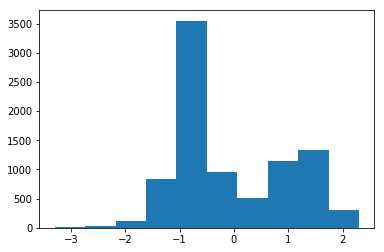

In [71]:
plt.figure()
plt.hist(sptmm_results.resid_deviance)
plt.show()

## Simple Binomial teams minutes form model

### Preparing data

In [119]:
sptmmf_df = element_gameweek_df.copy()

In [120]:
sptmmf_df = player.add_categorical_variables(sptmmf_df, 'element_type')
sptmmf_df = player.add_categorical_variables(sptmmf_df, 'opposition_team')
sptmmf_df = player.add_categorical_variables(sptmmf_df, 'own_team')

In [121]:
sptmmf_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling'
]

In [122]:
sptmmf_df['log_minutes'] = np.log(sptmmf_df['minutes'])

In [123]:
sptmmf_df = player.remove_redundant_columns(sptmmf_df, sptmmf_redundant_columns)

In [124]:
sptmmf_response_df, sptmmf_explanatory_df = player.get_response_explanatory_dfs(sptmmf_df, 'clean_sheets_no_time')

In [125]:
sptmmf_explanatory_df.columns

Index(['const', 'was_home', 'goals_conceded_per_minute_rolling',
       'element_type_2', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [126]:
sptmmf_results = sm.GLM(
    sptmmf_response_df,
    sptmmf_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [127]:
print(sptmmf_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8309
Model:                              GLM   Df Residuals:                     8264
Model Family:                  Binomial   Df Model:                           44
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4403.9
Date:                  Tue, 09 Apr 2019   Deviance:                       8807.8
Time:                          15:33:09   Pearson chi2:                 8.44e+03
No. Iterations:                       5                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.9940      0.279      7.146 

### Model fit

In [128]:
sptmmf_results.aic

8897.845433949165

In [129]:
sptmmf_results.bic

-65775.53587489823

In [130]:
sptmmf_pearson_results = goodness_fit.pearson_chi_squared_test(sptmmf_results)
sptmmf_pearson_results

(False, 0.08639778191938396)

In [131]:
sptmmf_results.resid_deviance.describe()

count    8309.000000
mean       -0.078679
std         1.026632
min        -2.953454
25%        -0.828116
50%        -0.523405
75%         0.958720
max         2.426374
dtype: float64

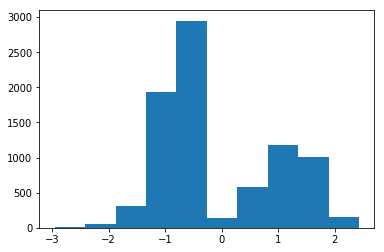

In [132]:
plt.figure()
plt.hist(sptmmf_results.resid_deviance)
plt.show()

## Simple Binomial player model

### Preparing data

In [86]:
sppm_df = element_gameweek_df.copy()

In [87]:
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [88]:
sppm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling', 'goals_conceded_per_minute_rolling'
]

In [89]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [90]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'clean_sheets_no_time')

In [91]:
sppm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_592', 'element_593', 'element_594', 'element_599',
       'element_601', 'element_602', 'element_603', 'element_605',
       'element_607', 'element_608'],
      dtype='object', length=513)

### Fitting model

In [92]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [93]:
print(sppm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8802
Model:                              GLM   Df Residuals:                     8289
Model Family:                  Binomial   Df Model:                          512
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4942.8
Date:                  Tue, 09 Apr 2019   Deviance:                       9885.5
Time:                          15:28:36   Pearson chi2:                 8.58e+03
No. Iterations:                      23                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2877      0.867     -2.639      0.008      -3.987      -0.589
was_home  

### Model fit

In [94]:
sppm_results.aic

10911.547370988768

In [95]:
sppm_results.bic

-65401.23680546975

In [96]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(True, 0.011451871522682566)

In [97]:
sppm_results.resid_deviance.describe()

count    8802.000000
mean       -0.070967
std         1.057446
min        -2.311200
25%        -0.888197
50%        -0.559138
75%         1.039135
max         2.455263
dtype: float64

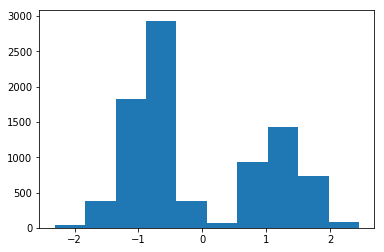

In [98]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Binomial player minutes model

### Preparing data

In [99]:
sppmm_df = element_gameweek_df.copy()

In [100]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [101]:
sppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes',
    'element_fixture_rank', 'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling',
    'goals_conceded_rolling', 'goals_conceded_per_minute_rolling'
]

In [102]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [103]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [104]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'clean_sheets_no_time')

In [105]:
sppmm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_593', 'element_594', 'element_599', 'element_601',
       'element_602', 'element_603', 'element_605', 'element_607',
       'element_608', 'log_minutes'],
      dtype='object', length=514)

### Fitting model

In [106]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [107]:
print(sppmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8802
Model:                              GLM   Df Residuals:                     8288
Model Family:                  Binomial   Df Model:                          513
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4532.6
Date:                  Tue, 09 Apr 2019   Deviance:                       9065.1
Time:                          15:29:20   Pearson chi2:                 8.90e+03
No. Iterations:                      23                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5123      0.900      2.791      0.005       0.748       4.277
was_home  

### Model fit

In [108]:
sppmm_results.aic

10093.144731466788

In [109]:
sppmm_results.bic

-66212.55671074435

In [110]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(True, 1.5488008735520253e-06)

In [111]:
sppmm_results.resid_deviance.describe()

count    8802.000000
mean       -0.072753
std         1.012284
min        -2.998817
25%        -0.817310
50%        -0.485533
75%         0.914616
max         2.643008
dtype: float64

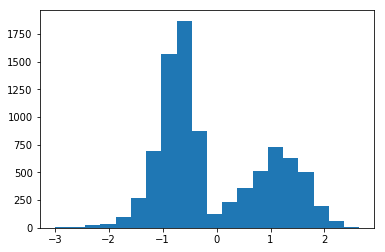

In [112]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.show()

# Model comparison

In [133]:
aic = {
    'Simple Binomial': spm_results.aic,
    'Binomial teams': sptm_results.aic,
    'Binomial players': sppm_results.aic,
    
    'Simple Binomial minutes': spmm_results.aic,
    'Binomial teams minutes': sptmm_results.aic,
    'Binomial teams minutes form': sptmmf_results.aic,
    'Binomial players minutes': sppmm_results.aic,
    }
aic

{'Simple Binomial': 11636.08788631826,
 'Binomial teams': 10540.643954975792,
 'Binomial players': 10911.547370988768,
 'Simple Binomial minutes': 10510.915651966397,
 'Binomial teams minutes': 9449.983426355566,
 'Binomial teams minutes form': 8897.845433949165,
 'Binomial players minutes': 10093.144731466788}

In [134]:
bic = {
    'Simple Binomial': spm_results.bic,
    'Binomial teams': sptm_results.bic,
    'Binomial players': sppm_results.bic,
    
    'Simple Binomial minutes': spmm_results.bic,
    'Binomial teams minutes': sptmm_results.bic,
    'Binomial teams minutes form': sptmmf_results.bic,
    'Binomial players minutes': sppmm_results.bic,
    }
bic

{'Simple Binomial': -68303.05622479423,
 'Binomial teams': -69101.02531774712,
 'Binomial players': -65401.23680546975,
 'Simple Binomial minutes': -69421.14572489871,
 'Binomial teams minutes': -70184.60311211996,
 'Binomial teams minutes form': -65775.53587489823,
 'Binomial players minutes': -66212.55671074435}

In [135]:
comp_df = pd.DataFrame([
    aic,
    bic
]).T
comp_df.columns = [
    'AIC',
    'BIC'
]
comp_df.astype('int64')

,AIC,BIC
Binomial players,10911,-65401
Binomial players minutes,10093,-66212
Binomial teams,10540,-69101
Binomial teams minutes,9449,-70184
Binomial teams minutes form,8897,-65775
Simple Binomial,11636,-68303
Simple Binomial minutes,10510,-69421
